In [113]:
import pandas as pd
import numpy as np
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering
import statsmodels.sandbox.stats.multicomp as sm
from scipy.stats import spearmanr

In [114]:
data = pd.read_csv(os.path.join('data', 'Pokemon.csv'))
data['Type 2']=data['Type 2'].replace('NaN', 'no')
data

,#,Name,Type 1,Type 2,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
0,1,Bulbasaur,Grass,Poison,318,45,49,49,65,65,45,1,False
1,2,Ivysaur,Grass,Poison,405,60,62,63,80,80,60,1,False
2,3,Venusaur,Grass,Poison,525,80,82,83,100,100,80,1,False
3,3,VenusaurMega Venusaur,Grass,Poison,625,80,100,123,122,120,80,1,False
4,4,Charmander,Fire,NaN,309,39,52,43,60,50,65,1,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,719,Diancie,Rock,Fairy,600,50,100,150,100,150,50,6,True
796,719,DiancieMega Diancie,Rock,Fairy,700,50,160,110,160,110,110,6,True
797,720,HoopaHoopa Confined,Psychic,Ghost,600,80,110,60,150,130,70,6,True
798,720,HoopaHoopa Unbound,Psychic,Dark,680,80,160,60,170,130,80,6,True


In [115]:
legendaries = data[data['Legendary']==True]
commons = data[data['Legendary']==False]

## Legendaries

In [118]:
def correlation_columns(data, class_to_predict):
    n = np.shape(data)[1]
    dict_corr = {}
    for feature in data.columns:
        if feature==class_to_predict:
            continue
        corr, pval = spearmanr(data[feature], data[class_to_predict])
        dict_corr[feature]= corr, pval
    return dict_corr

In [119]:
corr_pval = correlation_columns(data, 'Defense')
dict(sorted(corr_pval.items(), key=lambda x:x[1], reverse=True))

{'Type 2': (nan, nan),
 'Total': (0.6818641809814782, 1.7761307077750295e-110),
 'Sp. Def': (0.5788164910445328, 9.67370266103567e-73),
 'Attack': (0.5149946056788183, 2.1597981316449784e-55),
 'HP': (0.433401747319042, 5.744027179753025e-38),
 'Sp. Atk': (0.31421702523225425, 8.618117974741995e-20),
 'Legendary': (0.29099604717222644, 4.457456275161717e-17),
 '#': (0.11744373856339439, 0.0008742776305834208),
 'Speed': (0.09281775844217616, 0.0086179252559595),
 'Type 1': (0.08814145729136508, 0.012632174650459651),
 'Generation': (0.057776100452835426, 0.10247658852236204),
 'Name': (-0.023232001878090134, 0.5117203174792913)}

In [120]:
threshold_leg = [144, 243, 377, 480, 638, 716]
count=0
for gen in range(1, 7):
    print(gen)
    data_i = data[data['Generation']==gen]
    list_id = []
    for i in range(len(data_i['#'])):
        if data_i['#'][i+count]<threshold_leg[gen-1]:
            list_id.append(0)
        else:
            list_id.append(1)
    count+=len(data_i['#'])
    print(spearmanr(list_id, data_i['Legendary']))

1
SpearmanrResult(correlation=0.82872942075818, pvalue=3.408004176611526e-43)
2
SpearmanrResult(correlation=0.7589466384404111, pvalue=4.287719687643134e-21)
3
SpearmanrResult(correlation=0.9999999999999999, pvalue=0.0)
4
SpearmanrResult(correlation=1.0, pvalue=0.0)
5
SpearmanrResult(correlation=0.9713357558974813, pvalue=1.2702592152734779e-103)
6
SpearmanrResult(correlation=1.0, pvalue=0.0)


<AxesSubplot:>

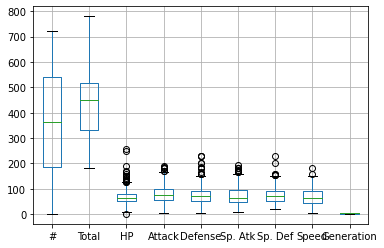

In [121]:
list_int_feature=[]
for feature in data.columns:
    if type(data[feature][0])==np.int64:
        list_int_feature.append(feature)
data.boxplot(column=list_int_feature)

# Clustering by unsupervised learning

In [122]:
def clustering_by_unsupervised_learning(data, feature1, feature2, class_to_predict):
    X = data[[feature1, feature2]]
    Y = data[class_to_predict]
    k=2
    plt.title("Two informative features, one cluster per class")
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='o', c=Y, s=25, edgecolor='k')
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

    # K-mean
    km = KMeans(n_clusters=k, init='k-means++', max_iter=100, n_init=1)
    km.fit(X)
    plt.title("K-MEAN")
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=10, c=km.labels_)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()

    # Hierarchical clustering
    clusterings = []
    for linkage in ('ward', 'average', 'complete'):
        clustering = AgglomerativeClustering(linkage=linkage, n_clusters=k)
        clustering.fit(X)
        clusterings.append(clustering)
        plt.xlabel(feature1)
        plt.ylabel(feature2)
        plt.title("Hierarchical clustering ("+linkage+")")
        plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=10, c=clustering.labels_)
        plt.show()

    # Spectral clustering
    spectral = cluster.SpectralClustering(n_clusters=k, eigen_solver='arpack', affinity="nearest_neighbors")
    spectral.fit(X)
    plt.title("Spectral Clustering")
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], s=10, c=spectral.labels_)
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.show()
    
    return km, clusterings, spectral

In [125]:
def evaluation(km, clusterings, spectral, X, Y):
    # comparison of the three methods
    methods = ['K-MEAN', 'Clustering(Ward)', 'Clustering (Average)', 'Clustering (Complete)', 'Spectral Clustering']
    list_results = [km, clusterings[0], clusterings[1], clusterings[2], spectral]
    Scores_1 = [[], [], [], [], []]
    
    for result in list_results:
        Scores_1[0].append(metrics.homogeneity_score(Y, result.labels_))
        Scores_1[1].append(metrics.completeness_score(Y, result.labels_))
        Scores_1[2].append(metrics.v_measure_score(Y, result.labels_))
        Scores_1[3].append(metrics.adjusted_rand_score(Y, result.labels_))
        Scores_1[4].append(metrics.silhouette_score(X, result.labels_))
    
    for i in range(5):
        print(methods[i])
        print("Homogeneity :", Scores_1[0][i])
        print("Completeness :", Scores_1[1][i])
        print("V-measure :", Scores_1[2][i])
        print("Adjusted Rand-Index :", Scores_1[3][i])
        print("Silhouette Coefficient :", Scores_1[4][i], '\n')

## Test on stat total and each stat

In [ ]:
for feature in ['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed']:
    print(feature)
    km, clusterings, spectral = clustering_by_unsupervised_learning(data, 'Total', feature, 'Legendary')
    evaluation(km, clusterings, spectral, data[['Total', feature]], data['Legendary'])

# DECISIONS TREE

In [5]:
clf = tree.DecisionTreeClassifier(criterion='entropy')
feature_int = [feature for feature in data.columns if type(data[feature][0])==np.int64 and feature not in ['Generation', '#']]
clf = clf.fit(data[feature_int], data['Legendary'])
class_pred_DT = clf.predict(data[feature_int])

In [6]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names=feature_int, 
                                class_names=['Not Legendary', 'Legendary'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(dot_data)
graph.render('Lengendary status (entropy)')

'Lengendary status (entropy).pdf'

In [11]:
data[feature_int]

,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed
0,318,45,49,49,65,65,45
1,405,60,62,63,80,80,60
2,525,80,82,83,100,100,80
3,625,80,100,123,122,120,80
4,309,39,52,43,60,50,65
...,...,...,...,...,...,...,...
795,600,50,100,150,100,150,50
796,700,50,160,110,160,110,110
797,600,80,110,60,150,130,70
798,680,80,160,60,170,130,80


In [23]:
print(clf.decision_path([[700, 100, 180, 120, 30, 70, 200]]))

  (0, 0)	1
  (0, 12)	1
  (0, 13)	1
  (0, 15)	1


C:\Users\llego\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


In [16]:
print(Counter(data['HP']))

Counter({60: 67, 50: 63, 70: 57, 65: 46, 80: 43, 75: 43, 45: 38, 40: 38, 55: 37, 100: 32, 90: 27, 95: 22, 85: 19, 35: 15, 30: 13, 105: 10, 78: 9, 110: 9, 44: 7, 79: 7, 91: 7, 68: 7, 62: 7, 58: 6, 59: 6, 38: 6, 20: 6, 64: 6, 106: 5, 72: 5, 76: 5, 67: 5, 74: 5, 61: 4, 73: 4, 125: 4, 150: 4, 86: 4, 71: 4, 108: 4, 54: 4, 63: 3, 83: 3, 115: 3, 130: 3, 48: 3, 41: 3, 43: 3, 66: 3, 77: 3, 49: 3, 103: 3, 120: 3, 89: 3, 39: 2, 46: 2, 25: 2, 52: 2, 84: 2, 53: 2, 57: 2, 69: 2, 123: 2, 82: 2, 126: 2, 81: 1, 140: 1, 10: 1, 250: 1, 160: 1, 190: 1, 255: 1, 28: 1, 31: 1, 1: 1, 104: 1, 144: 1, 170: 1, 99: 1, 37: 1, 97: 1, 111: 1, 135: 1, 116: 1, 36: 1, 51: 1, 114: 1, 165: 1, 109: 1, 92: 1, 56: 1, 88: 1, 101: 1, 42: 1})


<function matplotlib.pyplot.show(close=None, block=None)>

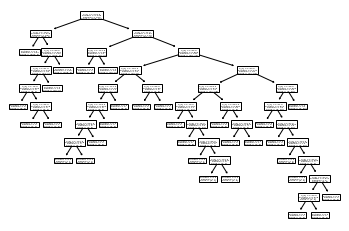

In [27]:
tree.plot_tree(clf)
plt.show

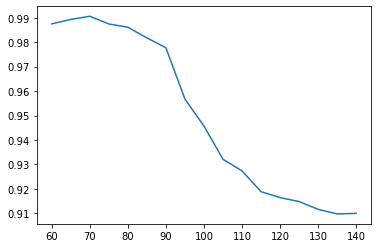

In [67]:
rate_common = []
for i in range(60, 145, 5):
    rate_common.append(len(commons[commons['Speed']<i])/len(data[data['Speed']<i]))
plt.plot(range(60, 145, 5), rate_common)
plt.show()

In [120]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(data[feature_int], data['Legendary'])
class_pred_RF = clf.predict(data[feature_int])

In [122]:
importance = clf.feature_importances_
print(importance)

[0.39073476 0.08393827 0.04904614 0.06680186 0.18185804 0.08710185
 0.14051906]


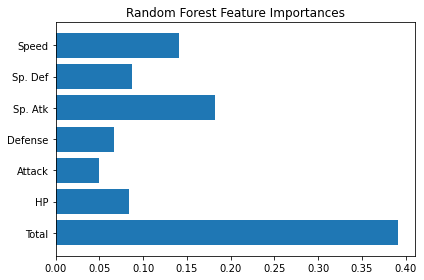

In [125]:
y_ticks = np.arange(0, len(feature_int))
fig, ax = plt.subplots()
ax.barh(y_ticks, importance)
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_int)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

# LOGISTIC REGRESSION

In [96]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(C = 1e40)
clf.fit(data[features_int], data['Legendary'])
print(clf.coef_)

[[10.53944942 10.53759017  4.69996252  9.13588572]]


In [131]:
#data = pd.read_csv('data/Pokemon.csv')
data = pd.read_csv('data/pokemon_dataset_2.csv')
#features_int = [feature for feature in data.columns if type(data[feature][0])==np.int64 and feature not in ['Generation', '#']]
features_int = ['Total', 'base_egg_steps', 'base_happiness', 'experience_growth']
print(features_int, '\n')
normalize_features(data, features_int)
updateTypeColumn(data, 'Legendary', True)
data['Legendary'] = data['Legendary'].apply(int) # Converts column to int
data = data[features_int+['Legendary']]

#accuracy, error = K_fold_logistic_regression(data, features_int, 'Legendary', 5, iterations=4000)
accuracy, error, theta = K_fold_logistic_regression(data, features_int, 'Legendary', 5, iterations=4000, N=10)
print('\nAverage accuracy :', accuracy)
print('Average error :', error)
print('Average Theta :', theta)

2 / 10


KeyboardInterrupt: 

In [58]:
dict((features_int[i], theta[i]) for i in range(len(features_int)))

{'Total': -0.29034764495973714,
 'base_egg_steps': 0.2449723325852859,
 'base_happiness': -0.3599471360710367,
 'experience_growth': -0.5550623401290578}

In [49]:
print(data[features_int].iloc[149, :])
n = np.dot(np.transpose(theta), data[features_int].iloc[149, :])
print(n, sigmoid(n))

Total                1.000000
base_egg_steps       1.000000
base_happiness       0.000000
experience_growth    0.762195
Name: 149, dtype: float64
0.41646569919165927 0.6026372141738523


In [59]:
for i in range(800):
    n = np.dot(np.transpose(theta), data[features_int].iloc[i, :])
    if sigmoid(n)>=0.5:
        print(i)

In [10]:
from src.logistic_regression import *
from src.special_method import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['figure.dpi'] = 100 

In [11]:
def normalize_features(data, features):
    for feature in features:
        data[feature] = data[feature].div(max(data[feature]), axis=0)
    return data

In [14]:
#data = pd.read_csv('data/Pokemon.csv')
data = pd.read_csv('data/pokemon_dataset_2.csv')
#features_int = [feature for feature in data.columns if type(data[feature][0])==np.int64 and feature not in ['Generation', '#']]
features_int = ['Total', 'base_egg_steps', 'base_happiness', 'experience_growth']
print(features_int, '\n')
normalize_features(data, features_int)
updateTypeColumn(data, 'Legendary', True)
data['Legendary'] = data['Legendary'].apply(int) # Converts column to int
data = data[features_int+['Legendary']]

['Total', 'base_egg_steps', 'base_happiness', 'experience_growth'] 



10 / 10


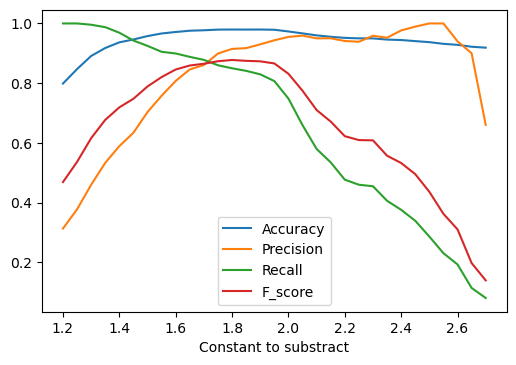

In [13]:
Accuracy, Precision, Recall, F_score = [], [], [], []
for l in np.arange(1.2, 2.7, 0.05):
    acc, pre, rec, f_score = K_fold_liam_method(data, features_int, 'Legendary', 5, 10, l)
    Accuracy.append(acc)
    Precision.append(pre)
    Recall.append(rec)
    F_score.append(f_score)
plt.plot(np.arange(1.2, 2.7, 0.05), Accuracy, label='Accuracy')
plt.plot(np.arange(1.2, 2.7, 0.05), Precision, label='Precision')
plt.plot(np.arange(1.2, 2.7, 0.05), Recall, label='Recall')
plt.plot(np.arange(1.2, 2.7, 0.05), F_score, label='F_score')
plt.legend()
plt.xlabel("Constant to substract")
plt.show()

10 / 10


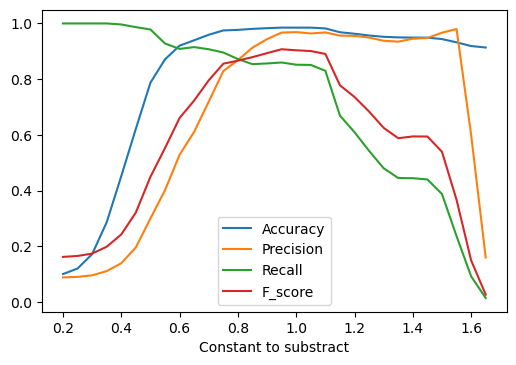

In [15]:
Accuracy, Precision, Recall, F_score = [], [], [], []
for l in np.arange(0.2, 1.7, 0.05):
    acc, pre, rec, f_score = K_fold_liam_method(data, features_int, 'Legendary', 5, 10, l)
    Accuracy.append(acc)
    Precision.append(pre)
    Recall.append(rec)
    F_score.append(f_score)
plt.plot(np.arange(0.2, 1.7, 0.05), Accuracy, label='Accuracy')
plt.plot(np.arange(0.2, 1.7, 0.05), Precision, label='Precision')
plt.plot(np.arange(0.2, 1.7, 0.05), Recall, label='Recall')
plt.plot(np.arange(0.2, 1.7, 0.05), F_score, label='F_score')
plt.legend()
plt.xlabel("Constant to substract")
plt.show()

In [5]:
from src.special_method import *
K_fold_liam_method(data, features_int, 'Legendary', 5, 10, 1.75)

10 / 10


(0.9791537267080745, 0.8984883645766, 0.8630308584940433, 0.8755225116609081)